In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# Checking version of tensorflow
import tensorflow as tf
print(tf.__version__)

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import  Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers, Model


# tpu related


In [ ]:
# Check if 'COLAB_TPU_ADDR' is in the environment variables
assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

# Define the TPU address
tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']

# Create a TPUClusterResolver
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)

# Connect to the TPU cluster
tf.config.experimental_connect_to_cluster(resolver)

# Initialize the TPU system
tf.tpu.experimental.initialize_tpu_system(resolver)

# Check and print the logical TPU devices
print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tf.config.list_logical_devices('TPU')))


In [ ]:
strategy= tf.distribute.TPUStrategy(resolver)
print(strategy)

# code


In [ ]:
data = 'C:/Users/Student/sreekar/Master Dataset'

## preprocess


In [ ]:
# Creating a Data Generator Object
from keras.preprocessing.image import ImageDataGenerator

# Creating a Data Generator Object
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range= 40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True
)

test_datagen = ImageDataGenerator(rescale = 1.0/255)


In [ ]:
train_set = train_datagen.flow_from_directory(
    directory = data,
    target_size = (256,256),
    batch_size = 16,
    class_mode ='categorical'
    # subset = 'training'
)

Found 4038 images belonging to 673 classes.


In [ ]:
valid_set = train_datagen.flow_from_directory(
    directory = data,
    target_size = (256,256),
    batch_size = 16,
    class_mode ='categorical'
    # subset = 'validation'
)

Found 4038 images belonging to 673 classes.


## Extra

In [ ]:
import sys
from PIL import Image
sys.modules['Image'] = Image

In [ ]:
base = InceptionV3(weights='imagenet', include_top=False)
base.summary()

In [ ]:
inception_features_train = base.predict(train_set)
inception_features_val = base.predict(valid_set)

In [ ]:
from keras.utils import to_categorical
train_target = to_categorical(train_set.labels)
val_target = to_categorical(valid_set.labels)

## model

In [ ]:
base = InceptionV3(weights='imagenet', include_top=False, input_shape = (256,256,3))

# Freeze all layers in the base model
for layer in base.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(base)

model.add(Flatten())

model.add(Dense(1024, activation='gelu',
    activity_regularizer=regularizers.L1(1e-5)))

model.add(Dropout(0.1))

model.add(Dense(673, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import SGD
import tensorflow_addons as tfa

model.compile(optimizer=SGD(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=673, average='macro')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 1024)              75498496  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 673)               689825    
                                                                 
Total params: 97,991,105
Trainable params: 76,188,321
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     patience=0,
#     min_delta=0.001,
#     mode='max'
# )


In [ ]:
# Train the model
history = model.fit(train_set, validation_data=valid_set,
            epochs = 40, steps_per_epoch = 252,
                    validation_steps = 252, callbacks = [tensorboard_callback])

Epoch 1/40
252/252 [==============================] - 246s 947ms/step - loss: 6.6375 - accuracy: 0.0012 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0011 - val_loss: 6.4161 - val_accuracy: 0.0057 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0036
Epoch 2/40
252/252 [==============================] - 241s 957ms/step - loss: 6.4053 - accuracy: 0.0124 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0091 - val_loss: 6.2773 - val_accuracy: 0.0176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0143
Epoch 3/40
252/252 [==============================] - 235s 933ms/step - loss: 6.2761 - accuracy: 0.0144 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0096 - val_loss: 6.0777 - val_accuracy: 0.0300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0225
Epoch 4/40
252/252 [==============================] - 239s 948ms/step - loss: 6.0861 - accuracy: 0.0311 - precision: 0.0000e+00 - recall: 0.00

In [ ]:
# Save the model as HDF5
model.save('inception_40_72.h5')

In [ ]:
import pickle

# Save the history object to a pickle file
history_pickle_path = 'inception_40_72.pkl'
with open(history_pickle_path, 'wb') as file:
    pickle.dump(history.history, file)

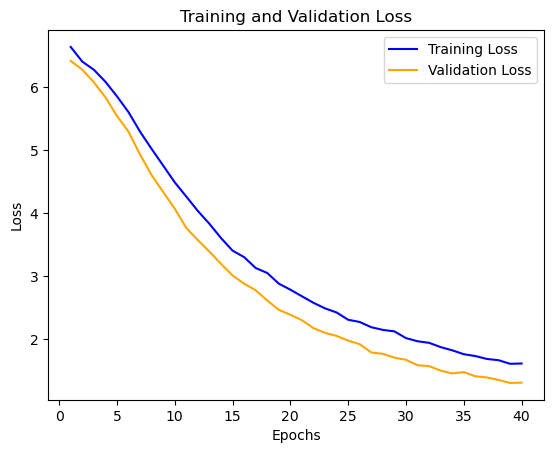

In [ ]:
# Load the training history from the pickle file
history_pickle_path = 'inception_40_72.pkl'

with open(history_pickle_path, 'rb') as file:
    history = pickle.load(file)

# Extract training and validation loss from the history
train_loss = history['loss']
val_loss = history['val_loss']

# Plot training and validation loss with specified colors
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training Loss')  # Blue color for training loss
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')  # Orange color for validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

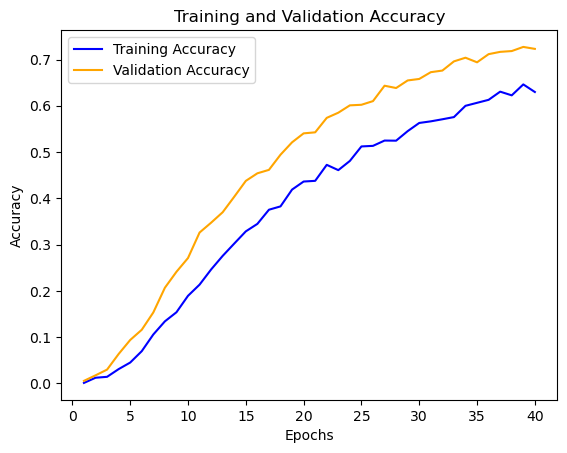

In [ ]:
# Load the training history from the pickle file
history_pickle_path = 'inception_40_72.pkl'

with open(history_pickle_path, 'rb') as file:
    history = pickle.load(file)

# Extract training and validation accuracy from the history
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Plot training and validation accuracy
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')  # Blue color for training accuracy
plt.plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')  # Orange color for validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Random

In [ ]:
# test_set = test_datagen.flow_from_directory(
#     target_size = (224, 224),
#     batch_size = 32,
#     rescale = 1./255,
#     class_mode = 'categorical'
# )

In [ ]:
# import os
# import matplotlib.pyplot as plt
# from PIL import Image

# master_dataset_dir = data
# folder_name = 'A14a'

# folder_path = os.path.join(master_dataset_dir, folder_name)

# for filename in os.listdir(folder_path):
#     image_path = os.path.join(folder_path, filename)

#     try:
#         image = Image.open(image_path)
#         plt.imshow(image)
#         plt.title("File name: " + filename)
#         plt.show()
#     except Exception as e:
#         print(f"Error occurred while processing {filename}: {e}")

In [ ]:

# x = layers.Dense(256, activation = 'gelu')(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(128, activation = 'gelu')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(64, activation = 'gelu')(x)
# x = layers.Dropout(0.1)(x)

# x = layers.Dense(num_classes,activation = 'softmax')(x)

In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders
# input_folder= '/content/gdrive/MyDrive/college/capstone/Master Dataset'
# splitfolders.ratio(input_folder, output= "Dataset",
#                    seed=42, ratio= (.8,.2), group_prefix= None)

In [ ]:
# !zip -r /content/Dataset.zip /content/Dataset